
# Final Project: *Face & Emotion Recognition* using face images and Deep Learning

### Team members: Diana Chacon, Jerico Johns, Joshua Jonte, & Sudhrity Mondal

### Class: W251-2 Tuesday 2:00 PM 
### Semester: Summer 2021
### Professor(s): Brad DesAulniers & Darragh Hanley

### Project Objective & Concept

The objective of this project is to capture live view feed from a camera connected to Nvidia Jetson Xavier NX edge device and:

- Detect a face in the video frame
- Recognize the face from the face image 
- Recognize the emotion from the face image

Deep Learning models for face detection, face recognition and facial emotion recognition are used in this project. The models are trained and validated on AWS with a GPU enabled instance and downloaded to Nvidia Jetson Xavier NX for detection and recognition of faces from live video stream. In addition, the same face image is used for facial emotion recognition. 

The high level architecture and system design for the project is shown below:


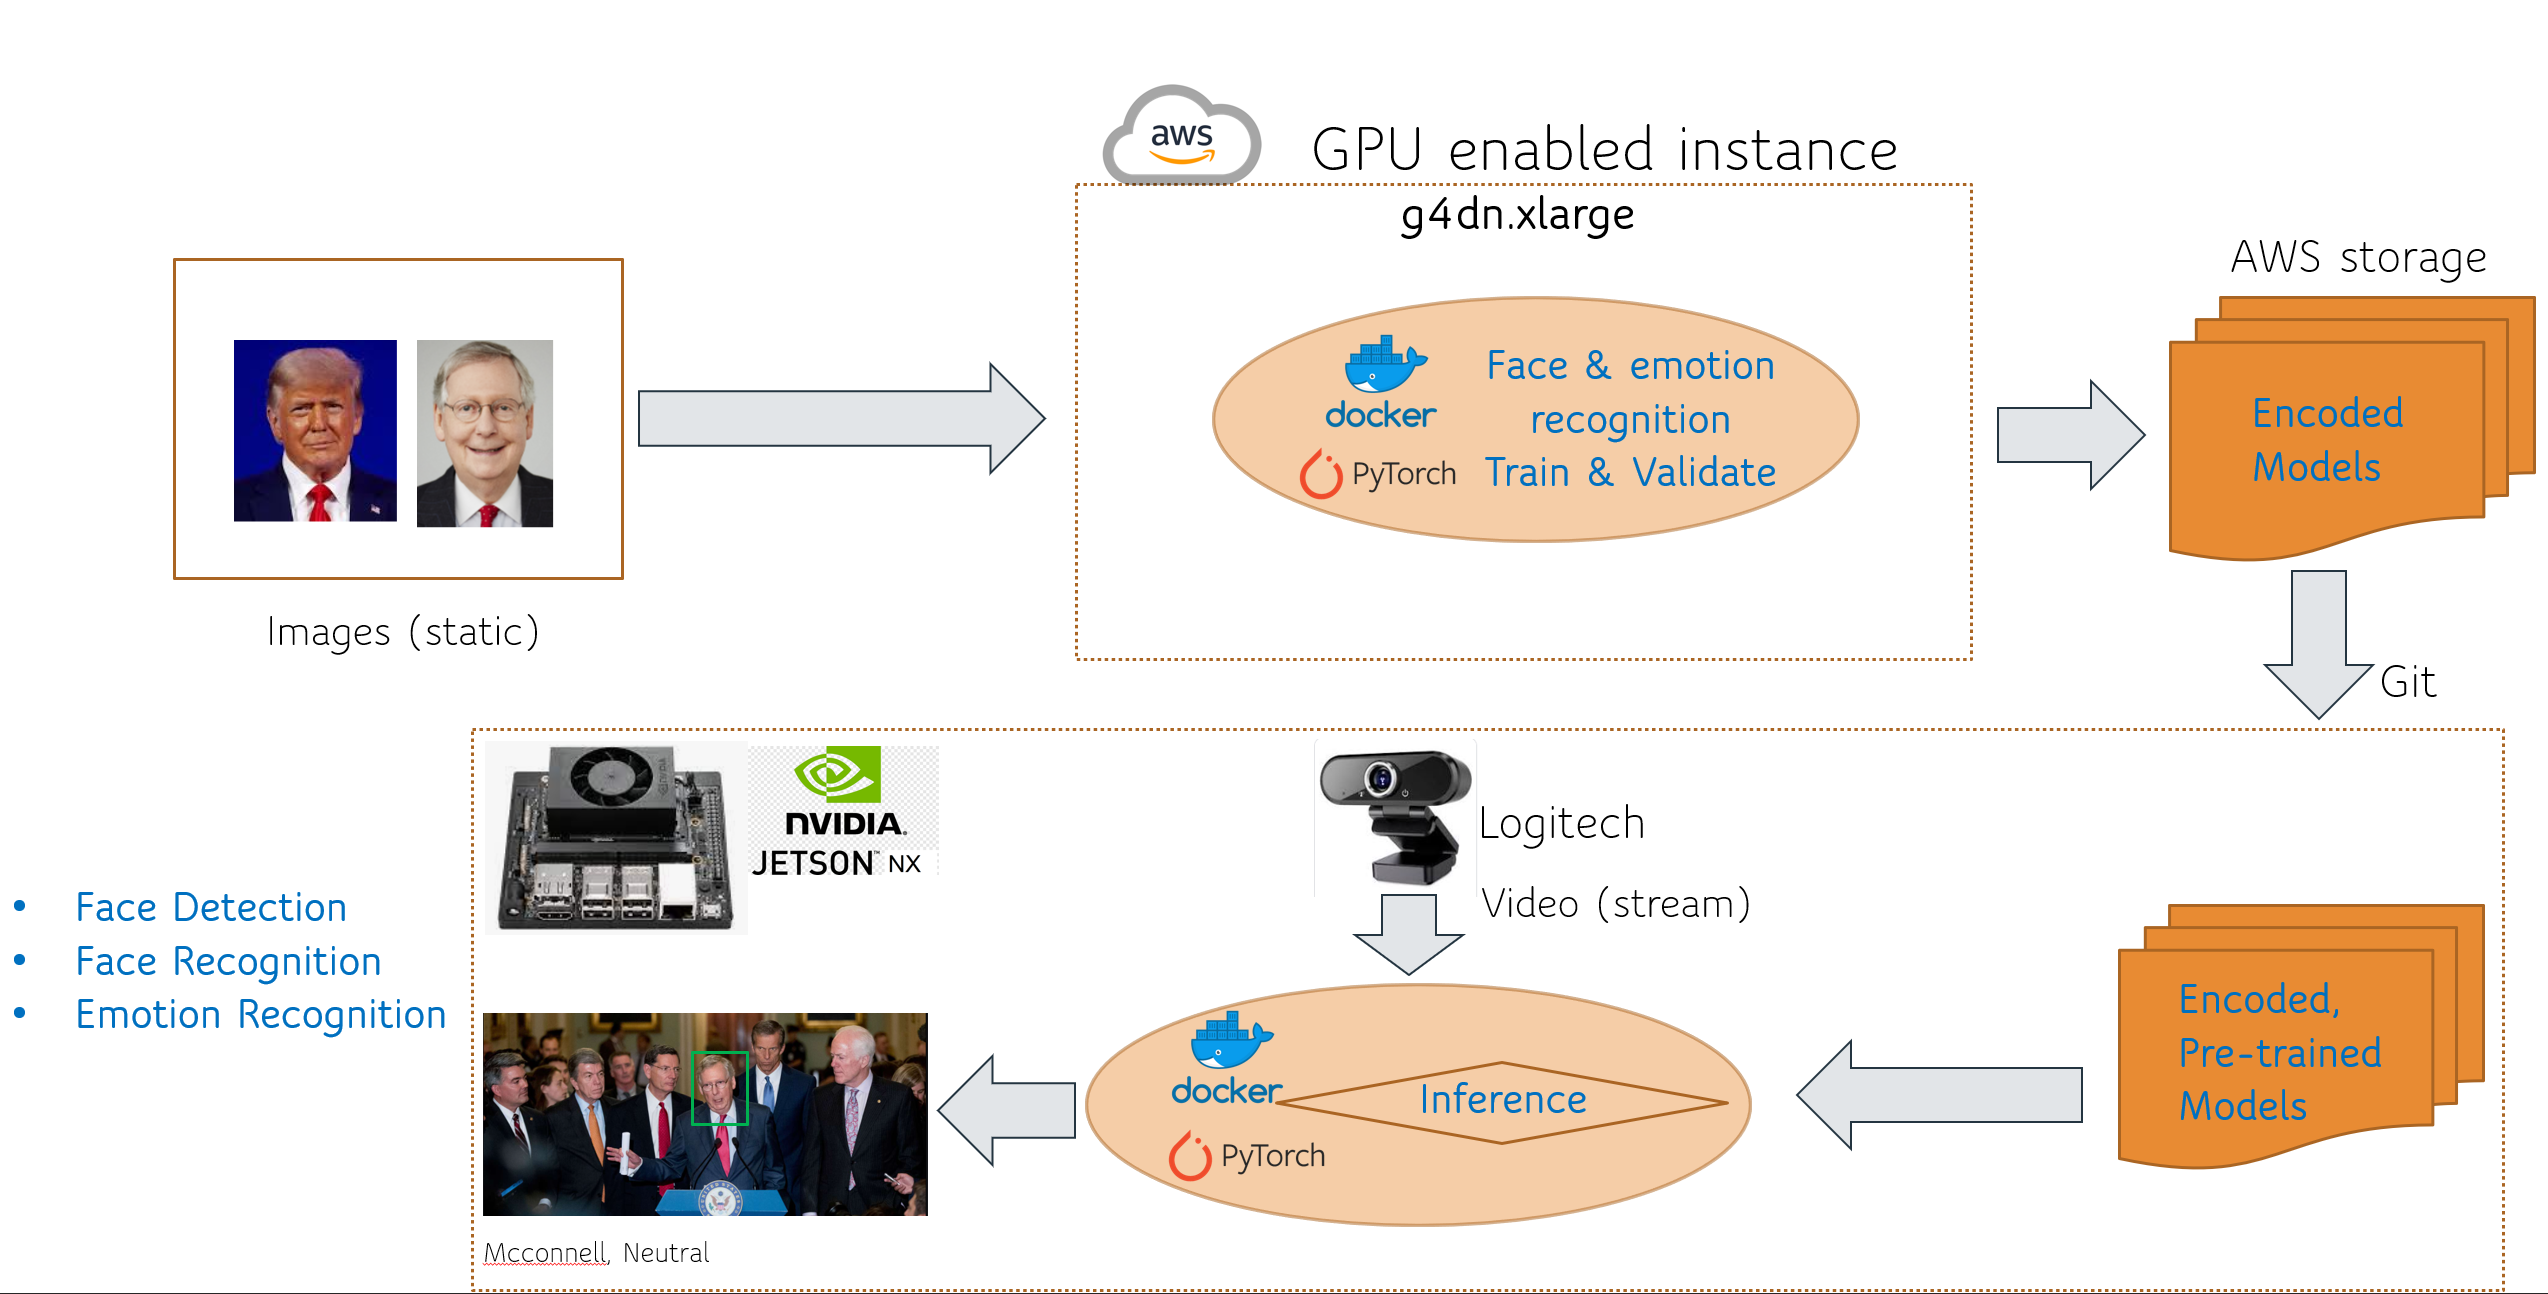

In [1]:
from IPython.display import Image
Image(filename='high-level-arch.png', width = 800, height = 500) 

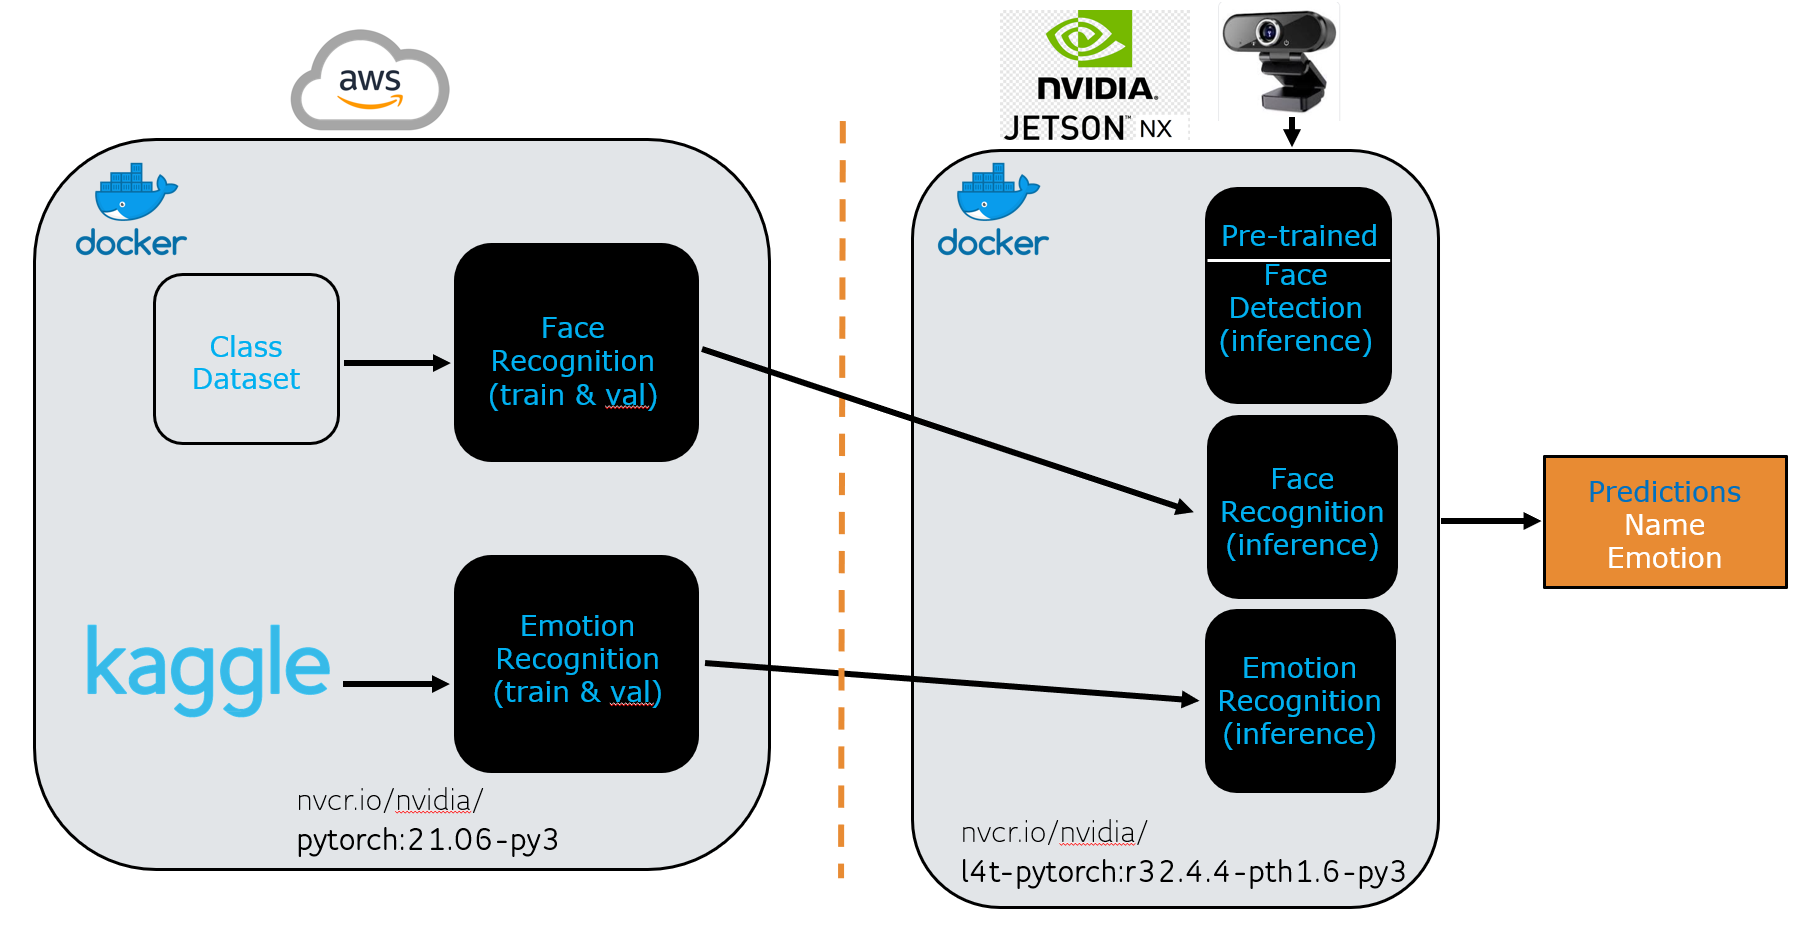

In [2]:
from IPython.display import Image
Image(filename='system-design.png', width = 800, height = 500) 

### Import Libraries

In [3]:
import cv2
import numpy as np

import torch
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

import matplotlib.pyplot as plt
import argparse
import os
from IPython.display import clear_output, display
from IPython.display import Image as IPImage
from facenet_pytorch import MTCNN

from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models

import torchvision.transforms as tt

from emotion_models import *
from face_encodings import *


### Execute on Jetson Xavier NX CUDA

In [4]:
cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {cuda_device}')

Running on device: cuda:0


### Face Recognition transfer learning - Load model

In [5]:
#The model requires two custom classes to load. 
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

#### Load Face Recognition transfer learning model

In [6]:
#Load our transfer trained model (with our custom classes for classmates)
model_face_recog = torch.load('../models/face_recognition_transf.pt')
model_face_recog.to(cuda_device)
model_face_recog.eval()

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

#### Transformations

In [7]:
#Now we load the data_transforms and class_names specified in the facerec_transfer_training notebook. 
data_transforms = {
    'train': transforms.Compose([
        #Note: Our images must be 160x160 for model (Training & Val). 
        transforms.Resize(size = (160,160)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size = (160,160)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '../data/face/images.m2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Alice_Hua',
 'Brad_DesAulniers',
 'Darragh_Hanley',
 'Diana_Chacon',
 'Divesh_Kumar',
 'Eric_Lundy',
 'Jerico_Johns',
 'Josh_Jonte',
 'Kevin_Martin',
 'Piotr_Parkitny',
 'Sudhrity_Mondal']

#### Face recognition - Inference

In [8]:
def get_face_name(face_img):
    #face_img = face_img / 256
    face_img = PILImage.fromarray((face_img))
    val_transform = data_transforms['val']
    face_img = val_transform(face_img).unsqueeze(0)
    with torch.no_grad(): 
        model_face_recog.eval()
        face_img = face_img.to(cuda_device)
        output = model_face_recog(face_img)
        top_p, pred = output.topk(1,dim =1)
        pred = pred.cpu()
        name = class_names[int(pred.numpy())]
        return name

### Emotion detection using Kaggle dataset with best accuracy

In [9]:
def load_trained_model(model_path):
    model = to_device(ResNet(1, 5), device)
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [10]:
def FER_image(img_path, model):


    emotion_dict = {0: 'Neutral', 1: 'Happy', 2: 'Surprise', 3: 'Sad', 4: 'Angry'}
    
    val_transform = tt.Compose([tt.ToTensor()])

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier('../models/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
        resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
        X = resize_frame/256
        X = PILImage.fromarray((resize_frame))
        X = val_transform(X).unsqueeze(0)
        with torch.no_grad():
            model.eval()
            log_ps = model.cpu()(X)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            pred = emotion_dict[int(top_class.numpy())]
        cv2.putText(img, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.axis('off')
    plt.show()

#### Load and run trained model for Emotion recognition

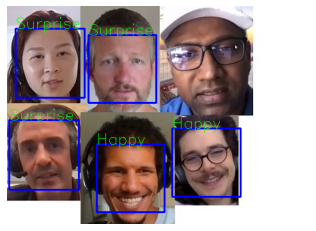

In [11]:
model_emotion_m1 = load_trained_model('../models/emotion_m1tr-0723_64e_.63.pth')
FER_image('../data/test_images/test4.jpg', model_emotion_m1)

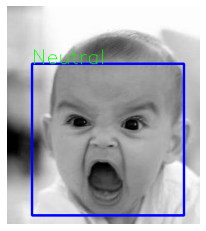

In [12]:
FER_image('../data/test_images/angry_2.jpg', model_emotion_m1)

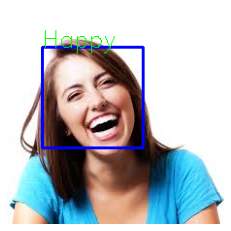

In [13]:
FER_image('../data/test_images/happy.jpeg', model_emotion_m1)

### Emotion detection using Pre-trained model with best accuracy

#### Load and run trained model for Emotion recognition

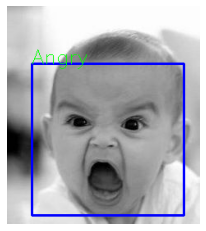

In [14]:
#Emotion recognition
def load_pretrained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model


model_emotion_m2 = load_pretrained_model('../models/emotion_m2pt.pt')
emotion_dict = {0: 'Neutral', 1: 'Happy', 2: 'Surprise', 3: 'Sad',
                    4: 'Angry', 5: 'Disgust', 6: 'Fear'}


FER_image('../data/test_images/angry_2.jpg', model_emotion_m2)

### Face Detection
#### Load Face Detection Pre-trained model

In [15]:
model_face_detect = MTCNN(keep_all=True, device=cuda_device)

### Integration Run 1 -  Run models with live Video stream using transfer learning for Face Recognition

In [16]:
video_capture = cv2.VideoCapture(0)
frame_count = 0

val_transform = tt.Compose([
        tt.ToTensor()])
    
try:
    while(True):
        frame_count += 1
        
        clear_output(wait=True)
        _, frame = video_capture.read()
        faces, _ = model_face_detect.detect(frame)
        
        if faces is not None:
            
            
            for top, left, bottom, right  in faces:
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
                resize_frame = cv2.resize(gray[int(top):int(bottom), int(left):int(right)], (48, 48))

                X = resize_frame/256
                X = PILImage.fromarray((X))
                X = val_transform(X).unsqueeze(0)
                with torch.no_grad():
                    model_emotion_m1.eval()
                    log_ps = model_emotion_m1.cpu()(X)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    pred = emotion_dict[int(top_class.numpy())] 
        
                #face_img = frame[0:300, 0:200]
                face_img = frame[int(top):int(bottom), int(left):int(right)]
                cv2.rectangle(frame, (top, left), (bottom, right), (0, 100, 0), 2)
                
                #Face name recognition
                rgb_face = face_img[:, :, ::-1]
                face_name = get_face_name(rgb_face)

                font = cv2.FONT_HERSHEY_DUPLEX
                x, y, w, h = int(top+2), int(right-50), int(left-2), int(bottom-26)

                scale = 0.045 # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
                fontScale = min(w,h)/(25/scale)

                cv2.putText(frame, face_name, ((int(top)+3), (int(right)-18)), font, fontScale, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(frame, pred, ((int(top)+3), (int(right)-4)), font, fontScale, (255, 255, 255), 1, cv2.LINE_AA)
               
   
        #ret, img = cv2.imencode('.jpg', frame)
        #img = IPImage(data=img)
        #display(img)
        
        # Display the resulting image
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    video_capture.release()
  
        
    

### Integration Run 2 -  Run models with live Video stream using pre-trained model for Face Recognition

In [17]:
video_capture = cv2.VideoCapture(0)

#Emotion recognition
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model


model = load_trained_model('../models/emotion_m2pt.pt')
emotion_dict = {0: 'Neutral', 1: 'Happy', 2: 'Surprise', 3: 'Sad',
                    4: 'Angry', 5: 'Disgust', 6: 'Fear'}


val_transform = transforms.Compose([
        transforms.ToTensor()])

In [18]:
try:
    while True:
        # Grab a single frame of video
        ret, frame = video_capture.read()

        process_this_frame = True

        # Resize frame of video to 1/4 size for faster face recognition processing
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_small_frame = small_frame[:, :, ::-1]

        # Only process every other frame of video to save time
        if process_this_frame:
            # Find all the faces and face encodings in the current frame of video
            face_locations = face_recognition.face_locations(rgb_small_frame)
            face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

            face_names = []
            for face_encoding in face_encodings:
                # See if the face is a match for the known face(s)
                matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
                name = "Unknown"

                face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = known_face_names[best_match_index]

                face_names.append(name)

        process_this_frame = not process_this_frame


        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
            #resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
            resize_frame = cv2.resize(gray[top:bottom, left:right], (48, 48))

            X = resize_frame/256
            X = Image.fromarray((X))
            X = val_transform(X).unsqueeze(0)
            with torch.no_grad():
                model.eval()
                log_ps = model.cpu()(X)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                pred = emotion_dict[int(top_class.numpy())] 

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 100, 0), 2)

            font = cv2.FONT_HERSHEY_DUPLEX
            x, y, w, h = left+2, bottom-50, right-2, bottom-26
            sub_img = frame[y:h, x:w]
            white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
            res = cv2.addWeighted(sub_img, 0.8, white_rect, 0.1, 1.0)
            frame[y:h, x:w] = res

            scale = 0.05 # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
            fontScale = min(w,h)/(25/scale)

            #cv2.putText(frame, name, (left + 6, bottom - 29), font, 1.0, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(frame, name, (left + 6, bottom - 29), font, fontScale, (255, 255, 255), 1, cv2.LINE_AA)

            font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(frame, pred, (left + 6, bottom - 4), font, 1.0, (34, 139, 34), 2, cv2.LINE_AA)


            # First we crop the sub-rect from the image
            x, y, w, h = left+2, bottom-25, right-2, bottom-2
            #sub_img = frame[y:y+h, x:x+w]
            sub_img = frame[y:h, x:w]
            white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
            res = cv2.addWeighted(sub_img, 0.6, white_rect, 0.2, 1.0)

            # Putting the image back to its position
            #frame[y:y+h, x:x+w] = res
            frame[y:h, x:w] = res
            #cv2.putText(frame, pred, (left + 6, bottom - 4), font, fontScale, (34, 139, 34), 2, cv2.LINE_AA)
            cv2.putText(frame, pred, (left + 6, bottom - 4), font, fontScale, (255, 0, 255), 1, cv2.LINE_AA)

        #ret, img = cv2.imencode('.jpg', frame)
        #img = IPImage(data=img)
        #display(img)

        # Display the resulting image
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    video_capture.release()